# Machine Learning Engineer Nanodegree


## Project: Yelp Restaurant Photo Classification


### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import sys

import caffe
import os
import time
import random

from sklearn import svm, datasets
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

from skimage import io
from skimage.transform import rotate
from skimage.exposure import adjust_gamma

from collections import Counter

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Define caffe and dataset root
caffe_root = '/home/ubuntu/src/caffe/'
dataset_root = '/home/ubuntu/yelp_classification/data/'

test_dataset_root = '/home/ubuntu/'

# Using python, so insert python into caffe root
sys.path.insert(0, caffe_root + 'python')

### Visualizing the dataset

In [3]:
############################
# Training set
############################

train_photos_to_business_id = pd.read_csv(dataset_root + 'train_photo_to_biz_ids.csv')

business_frequency_list = []
count = 0
for photo in train_photos_to_business_id['photo_id']:
    business_frequency_list.append(train_photos_to_business_id.loc[count]['business_id'])
    count += 1
    
print('Number of training images: {}'.format(len(business_frequency_list)))

Number of training images: 234842


In [18]:
biz_frequency_dict = Counter(business_frequency_list)

biz_values = biz_frequency_dict.values()

biz_total_photos = sum(biz_values)
biz_list_len = len(biz_frequency_dict.keys())

biz_max_photos = max(biz_values)
biz_min_photos = min(biz_values)

print('Maximum photos in a business for training set: {}'.format(biz_max_photos))
print('Minimum photos in a business for training set: {}'.format(biz_min_photos))

print('Average photos in a business for training set: {}'.format((biz_total_photos/biz_list_len)))

Maximum photos in a business for training set: 2974
Minimum photos in a business for training set: 2
Average photos in a business for training set: 117


In [5]:
############################
# Testing set
############################

test_photos_to_business_id = pd.read_csv(dataset_root + 'test_photo_to_biz.csv')

test_biz_freq_list = []

count = 0
for photo in test_photos_to_business_id['photo_id']:
    test_biz_freq_list.append(test_photos_to_business_id.loc[count]['business_id'])
    count += 1
    
print(len(test_biz_freq_list))


1190225


In [20]:
test_biz_freq_dict = Counter(test_biz_freq_list)

biz_values = test_biz_freq_dict.values()

biz_total_photos = sum(biz_values)
biz_list_len = len(test_biz_freq_dict.keys())

biz_max_photos = max(biz_values)
biz_min_photos = min(biz_values)

print('Maximum photos in a business for testing set: {}'.format(biz_max_photos))
print('Minimum photos in a business for testing set: {}'.format(biz_min_photos))

print('Average photos in a business for testing set: {}'.format((biz_total_photos/biz_list_len)))

Maximum photos in a business for testing set: 2825
Minimum photos in a business for testing set: 1
Average photos in a business for testing set: 119


In [3]:
############################
# Visualizing Training set
############################

y_training_labels = pd.read_csv(dataset_root + 'train.csv')

list_of_labels = []
count_of_non_zero_labels = 0

total_count = 0
for labels in y_training_labels['labels']:
    if (type(labels) is str):
        label_list = labels.split(' ')
        list_of_labels.append(label_list)
        count_of_non_zero_labels += 1
    
    total_count += 1

list_of_labels = np.concatenate(list_of_labels)

frequency_list = Counter(list_of_labels)

print('Number of zero labeled business in train set: {}'.format((total_count - count_of_non_zero_labels)))

Number of zero labeled business in train set: 4


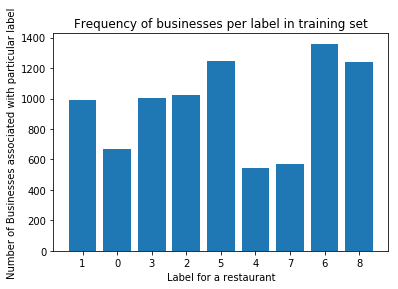

In [13]:
# Plotting bar chart

N = len(frequency_list)
keys = list(frequency_list.keys())
values = list(frequency_list.values())

plt.bar(range(N), values, align='center')
plt.xticks(range(N), keys)
plt.ylabel('Number of Businesses associated with particular label')
plt.xlabel('Label for a restaurant')
plt.title('Frequency of businesses per label in training set')
plt.show()

In [30]:
print('Sample of training set with labels\n')
print(y_training_labels[:5])

Sample of training set with labels

   business_id         labels
0         1000  1 2 3 4 5 6 7
1         1001        0 1 6 8
2          100    1 2 4 5 6 7
3         1006      1 2 4 5 6
4         1010          0 6 8


In [4]:
## Load mapping of Training Photos to Business IDs
train_photos_to_business_id = pd.read_csv(dataset_root + 'train_photo_to_biz_ids.csv')

print('Mapping of training photos to training business ids\n')
print(train_photos_to_business_id[:5])

Mapping of training photos to training business ids

   photo_id  business_id
0    204149         3034
1     52779         2805
2    278973          485
3    195284          485
4     19992          485


In [37]:
## Load mapping of Testing Photos to Business IDs
test_photos_to_business_id = pd.read_csv(dataset_root + 'test_photo_to_biz.csv')

print('Mapping of testing photos to training business ids\n')
print(test_photos_to_business_id[1000:1005])

Mapping of testing photos to training business ids

      photo_id business_id
1000    238721       021oz
1001    407713       021oz
1002    223604       021oz
1003    408898       021oz
1004    276062       021oz


### Data Augmentation

In [81]:
## Data Augmentation

# Create a DataFrame consisting of all the businesses that have either 0, 4 or 7 in their labels
# This is done as these classes have less data points.

list_of_businesses = []
list_of_augmented_labels = []

aug_label_dict = {}
aug_label_dict_2 = {}
count = 0
for labels, biz_id in zip(y_training_labels['labels'], y_training_labels['business_id']):
    if ( (type(labels) is str) and ( ('0' in labels) or ('4' in labels) or ('7' in labels) ) ):
        list_of_businesses.append(biz_id)
        list_of_augmented_labels.append(labels)
        aug_label_dict[biz_id] = labels


print('Total augmented businesses: {}'.format(len(list_of_businesses)))


aug_label_dict_2['business_id'] = list_of_businesses
aug_label_dict_2['labels'] = list_of_augmented_labels

aug_label_dataframe = pd.DataFrame(data=aug_label_dict_2)


Total augmented businesses: 1352


In [85]:
# Create a new DataFrame to store augmented photo_id for all the businesses found in previous step
aug_data_frame = pd.DataFrame(columns=['photo_id', 'business_id'])

count = 0

aug_image_list = []
aug_biz_list = []
aug_label_list = []

aug_img_dataset_dict = {}

# Go through all the rows in 'train_photos_to_business_id' and save only the photos whose 
# business id matches in augmented dataframe created earlier
for photo_id, biz_id in zip(train_photos_to_business_id['photo_id'], train_photos_to_business_id['business_id']):
    if biz_id in list_of_businesses:
        # Business matched, store photo_id, business_id and labels
        index_list = aug_label_dataframe.index[aug_label_dataframe['business_id'] == biz_id].tolist()
        aug_image_list.append(photo_id)
        aug_biz_list.append(biz_id)
        aug_label_list.append(aug_label_dataframe.at[index_list[0], 'labels'])
        count += 1
        
        if (count%10000) == 0:
            print('Processed: {}'.format(count))

print(count)

Processed: 10000
Processed: 20000
Processed: 30000
Processed: 40000
Processed: 50000
Processed: 60000
Processed: 70000
Processed: 80000
Processed: 90000
Processed: 100000
Processed: 110000
Processed: 120000
Processed: 130000
Processed: 140000
Processed: 150000
Processed: 160000
167775


In [86]:
#Process labels so that they only contain (0, 4, 7)
print(aug_label_list[:5])

aug_reduced_label_list = []
for single_row_labels in aug_label_list:
    labels_list = [int(i) for i in single_row_labels.split()]
    reduced_label_list = np.intersect1d(labels_list, [0, 4, 7])

    reduced_label_string = " ".join([str(i) for i in reduced_label_list])
    aug_reduced_label_list.append(reduced_label_string)

print(aug_reduced_label_list[:5])
print(len(aug_reduced_label_list))
print('Done')    
    

['1 2 3 5 6 7', '1 2 3 4 5 6 7', '1 2 3 4 5 6 7', '1 2 3 4 5 6 7', '1 2 3 4 5 6 7']
['7', '4 7', '4 7', '4 7', '4 7']
167775
Done


In [37]:
# Create a final dataframe consisting of photo_id, business_id and 'reduced' label list having [0, 4 or 7]
aug_img_dataset_dict['photo_id'] = aug_image_list
aug_img_dataset_dict['business_id'] = aug_biz_list
aug_img_dataset_dict['labels'] = aug_reduced_label_list

aug_data_frame = pd.DataFrame(data=aug_img_dataset_dict)

# Store aug data frame to file
with open(dataset_root + "augmented_photo_to_business_id.csv", 'w') as f:  
    aug_data_frame.to_csv(f, index=False)

print('Done')

Done


In [42]:
aug_data_frame = pd.read_csv(dataset_root + 'augmented_photo_to_business_id.csv')
print(aug_data_frame.head(5))

   business_id labels  photo_id
0         2805      7     52779
1          485    4 7    278973
2          485    4 7    195284
3          485    4 7     19992
4          485    4 7     80748


In [48]:
###########################################
# Create augmented images and store them (rotation and gamma correction)
###########################################

aug_root = '/home/ubuntu/aug_test_photos/'
def create_augmented_data(aug_frame):
    
    #Rotate image by 90 degree
    photo_ids_list = aug_data_frame['photo_id']
    
    count = 0
    for each_photo_id in photo_ids_list:
        photo_path = os.path.join(dataset_root + 'train_photos/', str(each_photo_id) + '.jpg')
        #print photo_path
    
        # Read image using scikit learn
        photo = io.imread(photo_path)
        
        rotation_choice_list = [90, 180, 270]
        
        # Rotate image by either 90, 180 or 270 degrees
        rotated_image = rotate(photo, random.choice(rotation_choice_list), resize=True)

        gamma_list = [0.25, 0.5, 2]

        # Adjust gamma of image
        gamma_adjusted_image = adjust_gamma(photo, random.choice(gamma_list))

        # Save rotate image and gamma adjusted image
        io.imsave(aug_root+str(each_photo_id)+'_rotated.jpg', rotated_image)
        io.imsave(aug_root+str(each_photo_id)+'_gamma.jpg', gamma_adjusted_image)
        
        count += 1
        
        if (count % 10000) == 0:
            print('Processed uptil now: {}'.format(count))
    
    print('Saved total images: '.format(count))
    

In [52]:
#print(count)
create_augmented_data(aug_data_frame)

In [58]:
# Create dataframe consisting of augmented image names (rotated and gamma appended) in prev augmented dataframe

def save_rotated_augmented_dataframe(aug_data_frame):
    aug_data_frame_copy = aug_data_frame.copy()
    
    photos_id_list = aug_data_frame_copy['photo_id']
    photos_id_rotated_list = []
    
    for photos_id in photos_id_list:
        photos_id_rotated_list.append(str(photos_id)+'_rotated')

    aug_rotated_img_dataset_dict = {}
    aug_rotated_img_dataset_dict['photo_id'] = photos_id_rotated_list

    aug_data_frame_copy['photo_id'] = aug_rotated_img_dataset_dict['photo_id']
    
    with open(dataset_root + "augmented_photo_to_business_id_rotated.csv", 'w') as f:  
        aug_data_frame_copy.to_csv(f, index=False)
        
    print('Saved rotated augmented data.')
    

    
def save_gamma_adjusted_augmented_dataframe(aug_data_frame):
    aug_data_frame_copy = aug_data_frame.copy()
    
    photos_id_list = aug_data_frame_copy['photo_id']
    photos_id_gamma_adjusted_list = []
    
    for photos_id in photos_id_list:
        photos_id_gamma_adjusted_list.append(str(photos_id)+'_gamma')


    aug_gamma_adjusted_img_dataset_dict = {}
    aug_gamma_adjusted_img_dataset_dict['photo_id'] = photos_id_gamma_adjusted_list

    aug_data_frame_copy['photo_id'] = aug_gamma_adjusted_img_dataset_dict['photo_id']
    
    with open(dataset_root + "augmented_photo_to_business_id_gamma_adjusted.csv", 'w') as f:  
        aug_data_frame_copy.to_csv(f, index=False)
        
    print('Saved gamma adjusted augmented data.')

In [59]:
save_rotated_augmented_dataframe(aug_data_frame)
save_gamma_adjusted_augmented_dataframe(aug_data_frame)

Saved rotated augmented data.
Saved gamma adjusted augmented data.


In [77]:
aug_rotated_data_frame = pd.read_csv(dataset_root + 'augmented_photo_to_business_id_rotated.csv')
print(aug_rotated_data_frame.head(5))

   business_id labels        photo_id
0         2805      7   52779_rotated
1          485    4 7  278973_rotated
2          485    4 7  195284_rotated
3          485    4 7   19992_rotated
4          485    4 7   80748_rotated


In [78]:
aug_gamma_data_frame = pd.read_csv(dataset_root + 'augmented_photo_to_business_id_gamma_adjusted.csv')
print(aug_gamma_data_frame.head(5))

   business_id labels      photo_id
0         2805      7   52779_gamma
1          485    4 7  278973_gamma
2          485    4 7  195284_gamma
3          485    4 7   19992_gamma
4          485    4 7   80748_gamma


### Load the Caffe Pre-trained Reference Model

In [69]:
# Check to see if CaffeNet is already downloaded, otherwise download it
if os.path.isfile(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print('CaffeNet found.')
else:
    print('Downloading pre-trained CaffeNet model...')
    !/home/ubuntu/src/caffe/scripts/download_model_binary.py /home/ubuntu/src/caffe/models/bvlc_reference_caffenet

CaffeNet found.


In [70]:
## Use GPU    
caffe.set_device(0)
caffe.set_mode_gpu()

### Get Image features from the second last layer ('fc7') of CaffeNet

In [71]:
def load_features(image_list, layer = 'fc7'):
    
    #######################################################################################
    # Reference: https://github.com/BVLC/caffe/blob/master/examples/00-classification.ipynb
    #######################################################################################

    # BVLC Caffenet model definition (layers etc)
    proto_file = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
    
    # BVLC Caffenet learned model weights
    caffemodel = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

    # Create a caffe 'Net'
    caffe_net = caffe.Net(proto_file, caffemodel, caffe.TEST)
    
    
    
    ## Pre-process the input images in form Caffe expects
    
    # Mean from image net
    mean_imagenet = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
    
    # average over pixels to obtain the mean (BGR) pixel values
    mean = mean_imagenet.mean(1).mean(1)
    
    
    # Create a transformer for loading images in form of caffenet and name it 'data'
    
    # By default the caffe transformer returns data shape as (10, 3, 227, 227).
    # This is because 10 random 227x227 crops are supposed to be extracted from a 256x256 image 
    # and passed through the net.
    transformer = caffe.io.Transformer({'data': caffe_net.blobs['data'].data.shape})
    
    # Transform image channels, input is (HxWxC) while caffe expects (CxHxW)
    transformer.set_transpose('data', (2,0,1))

    # subtract the dataset-mean value in each channel
    transformer.set_mean('data', mean)
    
    # rescale image data from [0, 1] to [0, 255] as caffe operates on images in range [0, 255] 
    transformer.set_raw_scale('data', 255)
    
    # Caffe expects images in BGR format while input is in RGB format, so swap it
    transformer.set_channel_swap('data', (2,1,0))

    
    
    total_images = len(image_list)
    
    # set the size of the input (batch_size, channel, height, width)
    caffe_net.blobs['data'].reshape(total_images, 3, 227, 227)
    
    # Load the images and transform them and save it in memory
    caffe_net.blobs['data'].data[...] = map(lambda img: transformer.preprocess('data', caffe.io.load_image(img)), image_list)
    
    ### perform classification using BVLC reference model 'caffe_net' created earlier
    out = caffe_net.forward()

    # Return the 'fc7' layer weights features
    return caffe_net.blobs[layer].data

### Extract features from training images and save it

In [36]:
# Save the extracted features for both test and train images for later use using H5PY library

# Read and close file first
h5py_train_file = h5py.File(dataset_root + 'train_images_fc7_features.h5', 'r+')
h5py_train_file.close()



# Open a h5py file for writing training features extracted using bvlc reference model
h5py_train_file = h5py.File(dataset_root + 'train_images_fc7_features.h5','w')

# Create dataset for image name
h5py_train_img_name = h5py_train_file.create_dataset('image_name', (0,), maxshape=(None,), dtype='|S54')

# Create dataset for image features
# Save features returned from bvlc fc7 layer (4096 features) to h5py file
h5py_train_img_feature = h5py_train_file.create_dataset('image_feature', (0,4096), maxshape = (None,4096))

h5py_train_file.close()

print("Created Train image features file!")


Created Train image features file!


In [7]:

# Get the Image full path using photo list from csv file
train_images = [os.path.join(dataset_root + 'train_photos/', str(x) + '.jpg') for x in train_photos_to_business_id['photo_id']]

total_train_images = len(train_images)
print("Total training images: {}".format(total_train_images))


Total training images: 234842


In [38]:
# Batch size to process image features
batch_size = 500

# Get the features for training Images
for count in range(0, total_train_images, batch_size):
    
    # Get the image path for this batch of images
    image_path = train_images[count: min((count + batch_size), total_train_images)]
    
    # Get features for all batch images
    train_img_features = load_features(image_path, layer='fc7')
    
    total_processed = count + train_img_features.shape[0]

    
    # Open the h5 file to store the image features for future use
    h5py_train_file = h5py.File(dataset_root + 'train_images_fc7_features.h5','r+')
    
    h5py_train_file['image_name'].resize((total_processed,))
    h5py_train_file['image_name'][count : total_processed] = np.array(image_path)
    
    h5py_train_file['image_feature'].resize((total_processed, train_img_features.shape[1]))
    h5py_train_file['image_feature'][count : total_processed, :] = train_img_features
    h5py_train_file.close()

    if (total_processed % 10000) == 0 or total_processed == total_train_images:
        print("Total images processed: {}".format(total_processed))

Total images processed: 10000
Total images processed: 20000
Total images processed: 30000
Total images processed: 40000
Total images processed: 50000
Total images processed: 60000
Total images processed: 70000
Total images processed: 80000
Total images processed: 90000
Total images processed: 100000
Total images processed: 110000
Total images processed: 120000
Total images processed: 130000
Total images processed: 140000
Total images processed: 150000
Total images processed: 160000
Total images processed: 170000
Total images processed: 180000
Total images processed: 190000
Total images processed: 200000
Total images processed: 210000
Total images processed: 220000
Total images processed: 230000
Total images processed: 234842


In [23]:
h5py_train_file = h5py.File(dataset_root + 'train_images_fc7_features.h5', 'r+')
print(h5py_train_file['image_name'][5:10])
print(h5py_train_file['image_feature'][5][:5])
print(h5py_train_file['image_feature'][6][:5])
print(h5py_train_file['image_feature'][7][:5])
print(h5py_train_file['image_feature'][8][:5])
print(h5py_train_file['image_feature'][9][:5])
h5py_train_file.close()

['/home/ubuntu/yelp_classification/data/train_photos/807'
 '/home/ubuntu/yelp_classification/data/train_photos/444'
 '/home/ubuntu/yelp_classification/data/train_photos/200'
 '/home/ubuntu/yelp_classification/data/train_photos/905'
 '/home/ubuntu/yelp_classification/data/train_photos/275']
[ 0.          2.72086954  0.          0.32762367  0.        ]
[ 1.82701159  0.          0.          2.56912136  0.        ]
[ 0.          0.          0.          0.          1.09389067]
[ 0.80203223  0.49244475  0.          1.40174103  0.52880692]
[ 0.  0.  0.  0.  0.]


### Extract features from augmented training images and save it

In [64]:
# Read and close file first
#h5py_aug_rotated_train_file = h5py.File(data_loc + 'aug_rotated_train_images_fc7_features.h5', 'r+')
#h5py_aug_rotated_train_file.close()


# Open a h5py file for writing training features extracted using bvlc reference model
h5py_aug_rotated_train_file = h5py.File(dataset_root + 'aug_rotated_train_images_fc7_features.h5','w')

# Create dataset for image name
h5py_aug_rotated_train_img_name = h5py_aug_rotated_train_file.create_dataset('image_name', (0,), maxshape=(None,), dtype='|S54')

# Create dataset for image features
# Save features returned from bvlc fc7 layer (4096 features) to h5py file
h5py_aug_rotated_train_img_feature = h5py_aug_rotated_train_file.create_dataset('image_feature', (0,4096), maxshape = (None,4096))

h5py_aug_rotated_train_file.close()

print("Created Augmented rotated Train image features file!")




# Open a h5py file for writing training features extracted using bvlc reference model
h5py_aug_gamma_train_file = h5py.File(dataset_root + 'aug_gamma_train_images_fc7_features.h5','w')

# Create dataset for image name
h5py_aug_gamma_train_img_name = h5py_aug_gamma_train_file.create_dataset('image_name', (0,), maxshape=(None,), dtype='|S54')

# Create dataset for image features
# Save features returned from bvlc fc7 layer (4096 features) to h5py file
h5py_aug_gamma_train_img_feature = h5py_aug_gamma_train_file.create_dataset('image_feature', (0,4096), maxshape = (None,4096))

h5py_aug_gamma_train_file.close()

print("Created Augmented gamma adjusted Train image features file!")

Created Augmented rotated Train image features file!
Created Augmented gamma adjusted Train image features file!


In [66]:

# Get the Image full path using photo list from csv file
aug_rotated_train_images = [os.path.join(aug_root, str(x) + '.jpg') for x in aug_rotated_data_frame['photo_id']]

total_aug_rotated_train_images = len(aug_rotated_train_images)
print("Total augmented rotated training images: {}".format(total_aug_rotated_train_images))




# Get the Image full path using photo list from csv file
aug_gamma_train_images = [os.path.join(aug_root, str(x) + '.jpg') for x in aug_gamma_data_frame['photo_id']]

total_aug_gamma_train_images = len(aug_gamma_train_images)
print("Total augmented gamma adjusted training images: {}".format(total_aug_gamma_train_images))



Total augmented rotated training images: 167775
Total augmented gamma adjusted training images: 167775


In [72]:
# Batch size to process image features
batch_size = 500

# Get the features for augmented rotated training Images
for count in range(0, total_aug_rotated_train_images, batch_size):
    
    # Get the image path for this batch of images
    image_path = aug_rotated_train_images[count: min((count + batch_size), total_aug_rotated_train_images)]
    
    # Get features for all batch images
    aug_rot_train_img_features = load_features(image_path, layer='fc7')
    
    total_processed = count + aug_rot_train_img_features.shape[0]

    
    # Open the h5 file to store the image features for future use
    h5py_aug_rotated_train_file = h5py.File(dataset_root + 'aug_rotated_train_images_fc7_features.h5','r+')
    
    h5py_aug_rotated_train_file['image_name'].resize((total_processed,))
    h5py_aug_rotated_train_file['image_name'][count : total_processed] = np.array(image_path)
    
    h5py_aug_rotated_train_file['image_feature'].resize((total_processed, aug_rot_train_img_features.shape[1]))
    h5py_aug_rotated_train_file['image_feature'][count : total_processed, :] = aug_rot_train_img_features
    h5py_aug_rotated_train_file.close()

    if (total_processed % 10000) == 0 or total_processed == total_aug_rotated_train_images:
        print("Total augmented rotated images processed: {}".format(total_processed))

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Total augmented rotated images processed: 10000
Total augmented rotated images processed: 20000
Total augmented rotated images processed: 30000
Total augmented rotated images processed: 40000
Total augmented rotated images processed: 50000
Total augmented rotated images processed: 60000
Total augmented rotated images processed: 70000
Total augmented rotated images processed: 80000
Total augmented rotated images processed: 90000
Total augmented rotated images processed: 100000
Total augmented rotated images processed: 110000
Total augmented rotated images processed: 120000
Total augmented rotated images processed: 130000
Total augmented rotated images processed: 140000
Total augmented rotated images processed: 150000
Total augmented rotated images processed: 160000
Total augmented rotated images processed: 167775


In [73]:
# Batch size to process image features
batch_size = 500

# Get the features for augmented rotated training Images
for count in range(0, total_aug_gamma_train_images, batch_size):
    
    # Get the image path for this batch of images
    image_path = aug_gamma_train_images[count: min((count + batch_size), total_aug_gamma_train_images)]
    
    # Get features for all batch images
    aug_gamma_train_img_features = load_features(image_path, layer='fc7')
    
    total_processed = count + aug_gamma_train_img_features.shape[0]

    
    # Open the h5 file to store the image features for future use
    h5py_aug_gamma_train_file = h5py.File(dataset_root + 'aug_gamma_train_images_fc7_features.h5','r+')
    
    h5py_aug_gamma_train_file['image_name'].resize((total_processed,))
    h5py_aug_gamma_train_file['image_name'][count : total_processed] = np.array(image_path)
    
    h5py_aug_gamma_train_file['image_feature'].resize((total_processed, aug_gamma_train_img_features.shape[1]))
    h5py_aug_gamma_train_file['image_feature'][count : total_processed, :] = aug_gamma_train_img_features
    h5py_aug_gamma_train_file.close()

    if (total_processed % 10000) == 0 or total_processed == total_aug_gamma_train_images:
        print("Total augmented gamma adjusted images processed: {}".format(total_processed))

Total augmented gamma adjusted images processed: 10000
Total augmented gamma adjusted images processed: 20000
Total augmented gamma adjusted images processed: 30000
Total augmented gamma adjusted images processed: 40000
Total augmented gamma adjusted images processed: 50000
Total augmented gamma adjusted images processed: 60000
Total augmented gamma adjusted images processed: 70000
Total augmented gamma adjusted images processed: 80000
Total augmented gamma adjusted images processed: 90000
Total augmented gamma adjusted images processed: 100000
Total augmented gamma adjusted images processed: 110000
Total augmented gamma adjusted images processed: 120000
Total augmented gamma adjusted images processed: 130000
Total augmented gamma adjusted images processed: 140000
Total augmented gamma adjusted images processed: 150000
Total augmented gamma adjusted images processed: 160000
Total augmented gamma adjusted images processed: 167775


In [88]:

y_training_labels = pd.read_csv(dataset_root + 'train.csv')

list_of_labels = []
count_of_non_zero_labels = 0

total_count = 0
for labels in y_training_labels['labels']:
    if (type(labels) is str):
        label_list = labels.split(' ')
        list_of_labels.append(label_list)
        count_of_non_zero_labels += 1
    
    total_count += 1

    
#Augmented data
for labels in list_of_augmented_labels:
    if (type(labels) is str):
        labels_list = [int(i) for i in labels.split()]
        reduced_label_list = np.intersect1d(labels_list, [0, 4, 7])

        reduced_label_string = " ".join([str(i) for i in reduced_label_list])
        
        label_list = reduced_label_string.split(' ')
        list_of_labels.append(label_list)
        
        count_of_non_zero_labels += 1
    
    total_count += 1


for labels in list_of_augmented_labels:
    if (type(labels) is str):
        labels_list = [int(i) for i in labels.split()]
        reduced_label_list = np.intersect1d(labels_list, [0, 4, 7])

        reduced_label_string = " ".join([str(i) for i in reduced_label_list])
        
        label_list = reduced_label_string.split(' ')
        list_of_labels.append(label_list)
        
        count_of_non_zero_labels += 1
    
    total_count += 1


list_of_labels = np.concatenate(list_of_labels)
frequency_list = Counter(list_of_labels)

print('Number of zero labeled business in train set: {}'.format((total_count - count_of_non_zero_labels)))



Number of zero labeled business in train set: 4


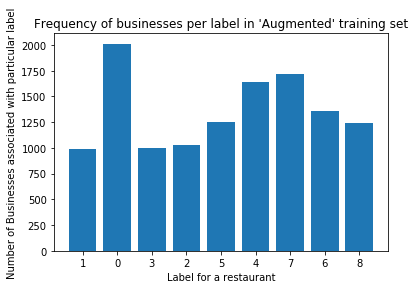

In [89]:
# Plotting bar chart after augmenting data to see if abnormality in dataset is reduced

N = len(frequency_list)
keys = list(frequency_list.keys())
values = list(frequency_list.values())

plt.bar(range(N), values, align='center')
plt.xticks(range(N), keys)
plt.ylabel('Number of Businesses associated with particular label')
plt.xlabel('Label for a restaurant')
plt.title('Frequency of businesses per label in \'Augmented\' training set')
plt.show()

### Extract features from Testing images and save it

In [5]:
# Save the extracted features for both test and train images for later use using H5PY library

# Read and close file first
h5py_test_file = h5py.File(dataset_root + 'test_images_fc7_features.h5', 'r+')
h5py_test_file.close()



# Open a h5py file for writing testing features extracted using bvlc reference model
h5py_test_file = h5py.File(dataset_root + 'test_images_fc7_features.h5','w')

# Create dataset for image name
h5py_test_img_name = h5py_test_file.create_dataset('image_name', (0,), maxshape=(None,), dtype='|S54')

# Create dataset for image features
# Save features returned from bvlc fc7 layer (4096 features) to h5py file
h5py_test_img_feature = h5py_test_file.create_dataset('image_feature', (0,4096), maxshape = (None,4096))

h5py_test_file.close()



print("Created Test image features file!")


Created Test image features file!


In [9]:
print("Total test photos to business id: {}".format(len(test_photos_to_business_id)))

print("Total unique test photos: {}".format(len(test_photos_to_business_id['photo_id'].unique())))


# Get the Image full path using photo list from csv file
test_images = [os.path.join(test_dataset_root + 'test_photos/', str(x) + '.jpg') for x in test_photos_to_business_id['photo_id'].unique()]

total_test_images = len(test_images)
print("Total test images: {}".format(total_test_images))


Total test photos to business id: 1190225
Total unique test photos: 237152
Total test images: 237152


In [11]:

# Batch size to process image features
batch_size = 500

# Get the features for testing Images
for count in range(0, total_test_images, batch_size):
    
    # Get the image path for this batch of images
    image_path = test_images[count: min((count + batch_size), total_test_images)]
    
    # Get features for all batch images
    test_img_features = load_features(image_path, layer='fc7')
    
    total_processed = (count + test_img_features.shape[0])

    
    # Open the h5 file to store the image features for future use
    h5py_test_file = h5py.File(dataset_root + 'test_images_fc7_features.h5','r+')
    
    h5py_test_file['image_name'].resize((total_processed,))
    h5py_test_file['image_name'][count : total_processed] = np.array(image_path)
    
    h5py_test_file['image_feature'].resize((total_processed, test_img_features.shape[1]))
    h5py_test_file['image_feature'][count : total_processed, :] = test_img_features
    h5py_test_file.close()

    if (total_processed % 1000) == 0 or total_processed == total_test_images:
        print("Total test images processed: {}".format(total_processed))
        
print('Done!!')

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Total test images processed: 1000
Total test images processed: 2000
Total test images processed: 3000
Total test images processed: 4000
Total test images processed: 5000
Total test images processed: 6000
Total test images processed: 7000
Total test images processed: 8000
Total test images processed: 9000
Total test images processed: 10000
Total test images processed: 11000
Total test images processed: 12000
Total test images processed: 13000
Total test images processed: 14000
Total test images processed: 15000
Total test images processed: 16000
Total test images processed: 17000
Total test images processed: 18000
Total test images processed: 19000
Total test images processed: 20000
Total test images processed: 21000
Total test images processed: 22000
Total test images processed: 23000
Total test images processed: 24000
Total test images processed: 25000
Total test images processed: 26000
Total test images processed: 27000
Total test images processed: 28000
Total test images processed: 

Total test images processed: 232000
Total test images processed: 233000
Total test images processed: 234000
Total test images processed: 235000
Total test images processed: 236000
Total test images processed: 237000
Total test images processed: 237152
Done!!


### Associate train image features to each business

In [41]:

# Dropping business with no labels
y_training_labels = pd.read_csv(dataset_root + 'train.csv').dropna()
#print(training_labels[:5])


# Convert space delimitted labels into tuples
y_training_labels['labels'] = y_training_labels['labels'].apply(lambda labels: tuple(sorted(int(label) for label in labels.split())))
#print(training_labels[:5])


# Set the main index of labels to business_id
y_training_labels.set_index('business_id', inplace=True)
#print("Training data after setting index to business id")
#print(training_labels[:5])


# Get the unique businesses in train file
train_business_ids = y_training_labels.index.unique()
#print("Business id")
#print(business_ids[:5])
#print('Total businesses: {}'.format(len(business_ids)))



# Load the training features from h5 file
X_train_features_file = h5py.File(dataset_root + 'train_images_fc7_features.h5', 'r')
X_train_features = np.copy(X_train_features_file['image_feature'])
X_train_features_file.close()



# Create a new DataFrame to store business, labels along with image features now
train_data_frame = pd.DataFrame(columns=['business_id', 'label', 'features'])

print('Done!')

Done!


In [42]:

count = 0

for business in train_business_ids:
    #if count < 1:
    #    print('Business: {}'.format(business))
    
    
    label_from_business = y_training_labels.loc[business]['labels']
    #if count < 1:
    #    print('Labels from business: {}'.format(label_from_business))
    
    
    business_list = train_photos_to_business_id[train_photos_to_business_id['business_id'] == business]
    #if count < 1:
    #    print('business_list:\n')
    #    print(business_list)
    
    
    business_list_index = train_photos_to_business_id[train_photos_to_business_id['business_id'] == business].index
    #if count < 1:
    #    print('business_list_index:\n')
    #    print(business_list_index)
    
    
    image_list = train_photos_to_business_id[train_photos_to_business_id['business_id'] == business].index.tolist()
    #if count < 1:
    #    print('Image_list:\n')
    #    print(image_list)
    
    
    feature_list = X_train_features[image_list]
    
    #if count < 1:
    #    print('feature_list:\n')
    #    print(feature_list)
     
    
    mean_feature = list(np.mean(feature_list, axis=0))
    
    #if count < 1:
    #    print('mean_feature:\n')
    #    print(mean_feature)
        
    train_data_frame.loc[count] = [business, label_from_business, mean_feature]
    
    count += 1
    
    if (count == len(train_business_ids)):
        print('Done pass: {}'.format(count))

        
# Store train data frame to file
with open(dataset_root + "train_business_label_fc7_features.csv", 'w') as f:  
    train_data_frame.to_csv(f, index=False)


Done pass: 1996


In [3]:
# Test if the features saved correctly
train_feature_csv = pd.read_csv(dataset_root + 'train_business_label_fc7_features.csv')

print('First five features')
print(train_feature_csv[:5])
print('Total length of features')
print(len(train_feature_csv))

First five features
   business_id                  label  \
0         1000  (1, 2, 3, 4, 5, 6, 7)   
1         1001           (0, 1, 6, 8)   
2          100     (1, 2, 4, 5, 6, 7)   
3         1006        (1, 2, 4, 5, 6)   
4         1010              (0, 6, 8)   

                                            features  
0  [0.19977085, 0.43287092, 0.22732987, 0.3551694...  
1  [0.0, 0.58893245, 0.53906047, 0.17221628, 0.01...  
2  [0.11155061, 0.034822084, 0.12025276, 0.520122...  
3  [0.078059338, 0.054452635, 0.05638162, 0.69423...  
4  [0.39657032, 0.27962369, 0.0, 0.17205141, 0.36...  
Total length of features
1996


### Associate Augmented training image features to each business

In [109]:

aug_rotated_data_frame_copy = aug_rotated_data_frame.copy()
aug_gamma_data_frame_copy = aug_gamma_data_frame.copy()

# Convert space delimitted labels into tuples
#aug_rotated_data_frame_copy['labels'] = aug_rotated_data_frame_copy['labels'].apply(lambda labels: tuple(sorted(int(label) for label in labels.split())))
#aug_gamma_data_frame_copy['labels'] = aug_gamma_data_frame_copy['labels'].apply(lambda labels: tuple(sorted(int(label) for label in labels.split())))

print(aug_rotated_data_frame_copy[:5])


# Set the main index of labels to business_id
aug_rotated_data_frame_copy.set_index('business_id', inplace=True)
aug_gamma_data_frame_copy.set_index('business_id', inplace=True)


# Get the unique businesses in train file
aug_rotated_train_business_ids = aug_rotated_data_frame_copy.index.unique()
aug_gamma_train_business_ids = aug_gamma_data_frame_copy.index.unique()

print('Done!')
print(len(aug_rotated_train_business_ids))


   business_id labels        photo_id
0         2805      7   52779_rotated
1          485    4 7  278973_rotated
2          485    4 7  195284_rotated
3          485    4 7   19992_rotated
4          485    4 7   80748_rotated
Done!
1352


In [94]:
# Load the training features from h5 file
X_aug_rotated_train_features_file = h5py.File(dataset_root + 'aug_rotated_train_images_fc7_features.h5', 'r')
X_aug_rotated_train_features = np.copy(X_aug_rotated_train_features_file['image_feature'])
X_aug_rotated_train_features_file.close()


X_aug_gamma_train_features_file = h5py.File(dataset_root + 'aug_gamma_train_images_fc7_features.h5', 'r')
X_aug_gamma_train_features = np.copy(X_aug_gamma_train_features_file['image_feature'])
X_aug_gamma_train_features_file.close()

# Create a new DataFrame to store business, labels along with image features now
final_aug_rotated_train_data_frame = pd.DataFrame(columns=['business_id', 'label', 'features'])
final_aug_gamma_train_data_frame = pd.DataFrame(columns=['business_id', 'label', 'features'])

print('Done!')

Done!


In [113]:
count = 0

for business in aug_rotated_train_business_ids:
    if count < 1:
        print('Business: {}'.format(business))
    
    label_from_business = aug_rotated_data_frame_copy.loc[business]['labels'].unique()
    
    if count < 1:
        print('Labels from business: {}'.format(label_from_business))
    
    
    image_list = aug_rotated_data_frame[aug_rotated_data_frame['business_id'] == business].index.tolist()
    if count < 1:
        print('Image_list:\n')
        print(image_list)
    
    
    feature_list = X_aug_rotated_train_features[image_list]
    
    #if count < 1:
    #    print('feature_list:\n')
    #    print(feature_list)
     
    
    mean_feature = list(np.mean(feature_list, axis=0))
    
    #if count < 1:
    #    print('mean_feature:\n')
    #    print(mean_feature)
        
    final_aug_rotated_train_data_frame.loc[count] = [business, label_from_business, mean_feature]
    
    count += 1
    
    if (count%10000 == 0) or (count == len(aug_rotated_train_business_ids)):
        print('Total processed: {}'.format(count))

        
# Store train data frame to file
with open(dataset_root + "aug_rotated_train_business_label_fc7_features.csv", 'w') as f:  
    final_aug_rotated_train_data_frame.to_csv(f, index=False)

Business: 2805
Labels from business: ['7']
Image_list:

[0, 1759, 1760, 8537, 8912, 10941, 11823, 15426, 15427, 16366, 16923, 17009, 17560, 17561, 17581, 17582, 17583, 17584, 17671, 21879, 22724, 25338, 26104, 29505, 44081, 44082, 45525, 45637, 45638, 45639, 49286, 54676, 54677, 55714, 55715, 59523, 63812, 63892, 66640, 67215, 67216, 67217, 69772, 69773, 70338, 70339, 70340, 75600, 75927, 85082, 85163, 87522, 90366, 92899, 94099, 97422, 97423, 102822, 103107, 103108, 103113, 107592, 107607, 107608, 107609, 107610, 107611, 108257, 108258, 108259, 111574, 111575, 112403, 113867, 118954, 118960, 118961, 118976, 121753, 121754, 122562, 125519, 125520, 125521, 125792, 126348, 128441, 128753, 128754, 129914, 140914, 149034, 149035, 149037, 153122, 153986, 153987, 153989, 153990, 153991, 153992, 153996, 153997, 153998, 153999, 156053, 157105, 157106, 157107, 157108, 157109, 157110, 157111, 157615, 161006, 161007, 161010, 162522, 164322]
Total processed: 1352


In [5]:

final_aug_rotated_train_data_frame = pd.read_csv(dataset_root + 'aug_rotated_train_business_label_fc7_features.csv')
print(final_aug_rotated_train_data_frame[:5])

   business_id    label                                           features
0         2805    ['7']  [0.37602994, 0.34450653, 0.13633271, 0.2259040...
1          485  ['4 7']  [0.4303605, 0.25506508, 0.17580706, 0.20345241...
2         1783    ['7']  [0.31403202, 0.20694035, 0.10624066, 0.1678360...
3         3216    ['7']  [0.35157824, 0.083742946, 0.20816316, 0.144753...
4         3385    ['4']  [0.57048815, 0.31142053, 0.068942636, 0.263724...


In [115]:
count = 0

for business in aug_gamma_train_business_ids:
    if count < 1:
        print('Business: {}'.format(business))
    
    label_from_business = aug_gamma_data_frame_copy.loc[business]['labels'].unique()
    
    if count < 1:
        print('Labels from business: {}'.format(label_from_business))
    
    
    image_list = aug_gamma_data_frame[aug_gamma_data_frame['business_id'] == business].index.tolist()
    if count < 1:
        print('Image_list:\n')
        print(image_list)
    
    
    feature_list = X_aug_gamma_train_features[image_list]
    
    #if count < 1:
    #    print('feature_list:\n')
    #    print(feature_list)
     
    
    mean_feature = list(np.mean(feature_list, axis=0))
    
    #if count < 1:
    #    print('mean_feature:\n')
    #    print(mean_feature)
        
    final_aug_gamma_train_data_frame.loc[count] = [business, label_from_business, mean_feature]
    
    count += 1
    
    if (count%10000 == 0) or (count == len(aug_gamma_train_business_ids)):
        print('Total processed: {}'.format(count))

        
# Store train data frame to file
with open(dataset_root + "aug_gamma_train_business_label_fc7_features.csv", 'w') as f:  
    final_aug_gamma_train_data_frame.to_csv(f, index=False)

Business: 2805
Labels from business: ['7']
Image_list:

[0, 1759, 1760, 8537, 8912, 10941, 11823, 15426, 15427, 16366, 16923, 17009, 17560, 17561, 17581, 17582, 17583, 17584, 17671, 21879, 22724, 25338, 26104, 29505, 44081, 44082, 45525, 45637, 45638, 45639, 49286, 54676, 54677, 55714, 55715, 59523, 63812, 63892, 66640, 67215, 67216, 67217, 69772, 69773, 70338, 70339, 70340, 75600, 75927, 85082, 85163, 87522, 90366, 92899, 94099, 97422, 97423, 102822, 103107, 103108, 103113, 107592, 107607, 107608, 107609, 107610, 107611, 108257, 108258, 108259, 111574, 111575, 112403, 113867, 118954, 118960, 118961, 118976, 121753, 121754, 122562, 125519, 125520, 125521, 125792, 126348, 128441, 128753, 128754, 129914, 140914, 149034, 149035, 149037, 153122, 153986, 153987, 153989, 153990, 153991, 153992, 153996, 153997, 153998, 153999, 156053, 157105, 157106, 157107, 157108, 157109, 157110, 157111, 157615, 161006, 161007, 161010, 162522, 164322]
Total processed: 1352


In [4]:

final_aug_gamma_train_data_frame = pd.read_csv(dataset_root + 'aug_gamma_train_business_label_fc7_features.csv')
print(final_aug_gamma_train_data_frame[:5])

   business_id    label                                           features
0         2805    ['7']  [0.099466562, 0.17942695, 0.30248374, 0.466066...
1          485  ['4 7']  [0.17786448, 0.20703655, 0.23062107, 0.4083034...
2         1783    ['7']  [0.17781542, 0.12470524, 0.35037681, 0.2263255...
3         3216    ['7']  [0.13506195, 0.25203982, 0.23938432, 0.2173104...
4         3385    ['4']  [0.19472842, 0.11007848, 0.28000301, 0.5795958...


### Associate testing image features to each business

In [4]:
## Load mapping of testing Photos to Business IDs
test_photo_to_business_id = pd.read_csv(dataset_root + 'test_photo_to_biz.csv')
#print(test_photo_to_business_id[:5])

test_business_ids = test_photo_to_business_id['business_id'].unique()



# Load the testing features from h5 file
X_test_features_file = h5py.File(dataset_root + 'test_images_fc7_features.h5', 'r')
X_test_image_name = list(np.copy(X_test_features_file['image_name']))
X_test_image_features = np.copy(X_test_features_file['image_feature'])
X_test_features_file.close()

print('Done!')

Done!


In [5]:
count = 0
for train_list_imgs in X_test_image_name:
    #print(train_list_imgs)
    if "317818" in train_list_imgs:
        #print(train_list_imgs)
        count += 1

print(count)

1


In [6]:
print(X_test_image_name[:5])

X_test_image_name_short = [name.split('/')[-1] for name in X_test_image_name]

print(X_test_image_name_short[:5])

X_test_image_name_short_without_ext = [name.split('.')[0] for name in X_test_image_name_short]

print(X_test_image_name_short_without_ext[:5])

['/home/ubuntu/test_photos/317818.jpg', '/home/ubuntu/test_photos/30679.jpg', '/home/ubuntu/test_photos/455084.jpg', '/home/ubuntu/test_photos/371381.jpg', '/home/ubuntu/test_photos/86224.jpg']
['317818.jpg', '30679.jpg', '455084.jpg', '371381.jpg', '86224.jpg']
['317818', '30679', '455084', '371381', '86224']


In [7]:
test_data_frame = pd.DataFrame(columns=['business_id', 'features'])
count = 0
t = time.time()

for business in test_business_ids:     
    
    #print('Processing business ID: {}'.format(business))
    
    photo_ids = test_photo_to_business_id[test_photo_to_business_id['business_id'] == business]['photo_id'].tolist()  
    
    #print('Photo IDs: {}'.format(photo_ids))
    
    #for ph in photo_ids:
    #    print('Photo: {}'.format(ph))
    #    print('X test: {}'.format(X_test_image_name_short_without_ext.index(str(ph))))
    
    image_index = [X_test_image_name_short_without_ext.index(str(photo)) for photo in photo_ids]
               
    test_features = X_test_image_features[image_index]
    
    test_mean_feature = list(np.mean(test_features, axis=0))

    test_data_frame.loc[count] = [business, test_mean_feature]
    
    count += 1
    
    if (count % 100) == 0:
        print "Buisness processed: ", count, "Time passed: ", "{0:.1f}".format(time.time()-t), "sec"


with open(dataset_root+"test_business_fc7_features.csv",'w') as f:  
    test_data_frame.to_csv(f, index=False)
    
print('Done!')

Buisness processed:  100 Time passed:  11.9 sec
Buisness processed:  200 Time passed:  26.6 sec
Buisness processed:  300 Time passed:  44.1 sec
Buisness processed:  400 Time passed:  60.6 sec
Buisness processed:  500 Time passed:  79.8 sec
Buisness processed:  600 Time passed:  103.4 sec
Buisness processed:  700 Time passed:  127.2 sec
Buisness processed:  800 Time passed:  153.0 sec
Buisness processed:  900 Time passed:  177.6 sec
Buisness processed:  1000 Time passed:  199.4 sec
Buisness processed:  1100 Time passed:  228.3 sec
Buisness processed:  1200 Time passed:  256.1 sec
Buisness processed:  1300 Time passed:  285.2 sec
Buisness processed:  1400 Time passed:  317.3 sec
Buisness processed:  1500 Time passed:  348.1 sec
Buisness processed:  1600 Time passed:  378.3 sec
Buisness processed:  1700 Time passed:  409.8 sec
Buisness processed:  1800 Time passed:  441.1 sec
Buisness processed:  1900 Time passed:  474.1 sec
Buisness processed:  2000 Time passed:  503.7 sec
Buisness proce

In [3]:
# Check file content
test_feature_csv = pd.read_csv(dataset_root+'test_business_fc7_features.csv')
print test_feature_csv.shape
test_feature_csv[0:5]

(10000, 2)


,business_id,features
0,003sg,"[0.19304767, 0.25836322, 0.19439411, 0.4623304..."
1,00er5,"[0.19397034, 0.25547439, 0.18416163, 0.3357919..."
2,00kad,"[0.12130528, 0.12655617, 0.076521836, 0.383440..."
3,00mc6,"[0.28427792, 0.11110595, 0.47849005, 0.4494445..."
4,00q7x,"[0.23811768, 0.33041945, 0.25544992, 0.3258045..."


### Use classifier to train on training dataset

In [4]:
def convert_label_to_array(str_label):
    str_label = str_label[1:-1]
    str_label = str_label.split(',')
    return [int(x) for x in str_label if len(x)>0]


def convert_feature_to_vector(str_feature):
    str_feature = str_feature[1:-1]
    str_feature = str_feature.split(',')
    return [float(x) for x in str_feature]

def convert_aug_label_to_array(str_label):
    str_label = str_label[2:-2]
    str_label = str_label.split(' ')
    return [int(x) for x in str_label if len(x)>0]

In [5]:
X_train_values = np.array([convert_feature_to_vector(y) for y in train_feature_csv['features']])

y_train_values = np.array([convert_label_to_array(y) for y in train_feature_csv['label']])


In [9]:
#Rotated augmentation
X_aug_rotated_train_values = np.array([convert_feature_to_vector(y) for y in final_aug_rotated_train_data_frame['features']])
y_aug_rotated_train_values = np.array([convert_aug_label_to_array(y) for y in final_aug_rotated_train_data_frame['label']])



#Gamma adjusted augmentation
X_aug_gamma_train_values = np.array([convert_feature_to_vector(y) for y in final_aug_gamma_train_data_frame['features']])
y_aug_gamma_train_values = np.array([convert_aug_label_to_array(y) for y in final_aug_gamma_train_data_frame['label']])



In [10]:
# Test dataset
X_test_values = np.array([convert_feature_to_vector(y) for y in test_feature_csv['features']])


In [11]:
X_final_train_values = np.append(X_train_values, X_aug_rotated_train_values, axis=0)

X_final_train_values = np.append(X_final_train_values, X_aug_gamma_train_values, axis=0)
print(len(X_final_train_values))

4700


In [12]:
y_final_train_values = np.append(y_train_values, y_aug_rotated_train_values, axis=0)

y_final_train_values = np.append(y_final_train_values, y_aug_gamma_train_values, axis=0)
print(len(y_final_train_values))

4700


In [14]:
mlb = MultiLabelBinarizer()

#Convert list of labels to binary matrix
y_train_one_hot_encoded = mlb.fit_transform(y_final_train_values)

print('Original Labels')
print(y_final_train_values[:5])

print('One hot encoded labels')
print(y_train_one_hot_encoded[:5])

Original Labels
[list([1, 2, 3, 4, 5, 6, 7]) list([0, 1, 6, 8]) list([1, 2, 4, 5, 6, 7])
 list([1, 2, 4, 5, 6]) list([0, 6, 8])]
One hot encoded labels
[[0 1 1 1 1 1 1 1 0]
 [1 1 0 0 0 0 1 0 1]
 [0 1 1 0 1 1 1 1 0]
 [0 1 1 0 1 1 1 0 0]
 [1 0 0 0 0 0 1 0 1]]


### Train a Linear SVM

In [6]:

t=time.time()

mlb = MultiLabelBinarizer()

#Convert list of labels to binary matrix
y_train_one_hot_encoded = mlb.fit_transform(y_train_values)

random_state = np.random.RandomState(0)

X_train, X_test, y_train, y_test = train_test_split(X_train_values, y_train_one_hot_encoded, test_size=.25, random_state=random_state)

classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))

classifier.fit(X_train, y_train)

y_predict = classifier.predict(X_test)

print "Time passed: ", "{0:.1f}".format(time.time()-t), "sec"



Time passed:  265.2 sec


In [12]:
####################
# Classifier details
####################

print(classifier.estimators_)

print(classifier.classes_)

print(classifier.multilabel_)

[SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False), SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False), SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False), SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False), SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr

In [7]:
print "F1 score using linear SVM : ", f1_score(y_test, y_predict, average='micro') 

F1 score using linear SVM :  0.801305970149


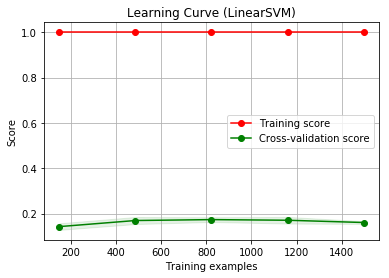

In [8]:
##########################################################################
# Plotting learning curve for training and validation set using LinearSVM
##########################################################################

linear_classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))

# Plot learning curve for Linear SVM
plt.figure()
plt.title("Learning Curve (LinearSVM)")

plt.xlabel("Training examples")
plt.ylabel("Score")

# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
train_sizes, train_scores, test_scores = learning_curve(
    linear_classifier, X_train_values, y_train_one_hot_encoded, cv=cv, n_jobs=4, train_sizes=np.linspace(.1, 1.0, 5))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

### Train a rbf kernel SVM

In [6]:
t=time.time()

mlb = MultiLabelBinarizer()

#Convert list of labels to binary matrix
y_train_one_hot_encoded = mlb.fit_transform(y_train_values)

random_state = np.random.RandomState(10)

X_train, X_test, y_train, y_test = train_test_split(X_train_values, y_train_one_hot_encoded, test_size=.25, random_state=random_state)

rbf_classifier = OneVsRestClassifier(svm.SVC(kernel='rbf', probability=True, random_state=random_state))

rbf_classifier.fit(X_train, y_train)

y_predict = rbf_classifier.predict(X_test)

print "Time passed for RBF SVC: ", "{0:.1f}".format(time.time()-t), "sec"

Time passed for RBF SVC:  306.0 sec


In [7]:
print "F1 score using rbf kernel SVM : ", f1_score(y_test, y_predict, average='micro') 

F1 score using rbf kernel SVM :  0.829973915106


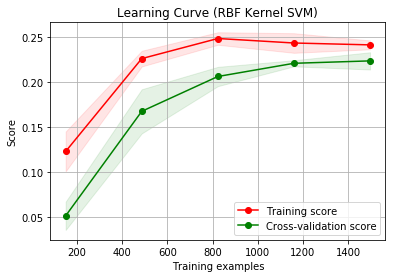

In [8]:
##########################################################################
# Plotting learning curve for training and validation set using RBF kernel
##########################################################################


plt.figure()
plt.title("Learning Curve (RBF Kernel SVM)")

plt.xlabel("Training examples")
plt.ylabel("Score")

# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=3, test_size=0.25, random_state=0)
train_sizes, train_scores, test_scores = learning_curve(
    rbf_classifier, X_train_values, y_train_one_hot_encoded, cv=cv, n_jobs=4, train_sizes=np.linspace(.1, 1.0, 5))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

### Train a SVM using GridSearchCV

In [17]:
t=time.time()

mlb = MultiLabelBinarizer()

#Convert list of labels to binary matrix
y_train_one_hot_encoded = mlb.fit_transform(y_final_train_values)

random_state = np.random.RandomState(10)

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10, 50], 'gamma':[1e-3, 1e-2, 0.2]}

#X_train, X_test, y_train, y_test = train_test_split(X_final_train_values, y_train_one_hot_encoded, test_size=.25, random_state=random_state)
svc = svm.SVC()

svm_grid_classifier = OneVsRestClassifier(GridSearchCV(svc, parameters, n_jobs=2, cv=3))

print('Fitting the data!')
svm_grid_classifier.fit(X_final_train_values, y_train_one_hot_encoded)

#y_predict = svm_grid_classifier.predict(X_test)

print "Time passed for RBF SVC: ", "{0:.1f}".format(time.time()-t), "sec"

Fitting the data!


NameError: name 'X_test' is not defined

In [44]:
count = 0
for each_label_classifier in svm_grid_classifier.estimators_:
    print("Best classifier for label {} has values:".format(svm_grid_classifier.classes_[count]))
    print(each_label_classifier.best_params_)
    count += 1
    print("\n")

Best classifier for label 0 has values:
{'kernel': 'rbf', 'C': 10, 'gamma': 0.01}


Best classifier for label 1 has values:
{'kernel': 'rbf', 'C': 1, 'gamma': 0.01}


Best classifier for label 2 has values:
{'kernel': 'rbf', 'C': 1, 'gamma': 0.01}


Best classifier for label 3 has values:
{'kernel': 'rbf', 'C': 1, 'gamma': 0.2}


Best classifier for label 4 has values:
{'kernel': 'linear', 'C': 1, 'gamma': 0.001}


Best classifier for label 5 has values:
{'kernel': 'rbf', 'C': 10, 'gamma': 0.01}


Best classifier for label 6 has values:
{'kernel': 'rbf', 'C': 10, 'gamma': 0.01}


Best classifier for label 7 has values:
{'kernel': 'linear', 'C': 1, 'gamma': 0.001}


Best classifier for label 8 has values:
{'kernel': 'rbf', 'C': 1, 'gamma': 0.001}




### Store testing data results for submission

In [171]:
########################
# Linear SVM
########################

y_predict_linear_svm = classifier.predict(X_test_values)

#Convert binary matrix back to labels
y_predict_label_linear_svm = mlb.inverse_transform(y_predict_linear_svm)
print('Done!')

Done!


In [172]:
final_test_df = pd.DataFrame(columns=['business_id', 'labels'])

for i in range(len(test_feature_csv)):
    
    biz = test_feature_csv.loc[i]['business_id']
    label = y_predict_label_linear_svm[i]
    label = str(label)[1:-1].replace(",", " ")
    final_test_df.loc[i] = [str(biz), label]

with open(dataset_root+"yelp_test_data_submission_linear_svm.csv",'w') as f:
    final_test_df.to_csv(f, index=False)
    
print('Done')

Done


In [173]:
########################
# RBF SVM
########################

y_predict_rbf_svm = rbf_classifier.predict(X_test_values)

#Convert binary matrix back to labels
y_predict_label_rbf_svm = mlb.inverse_transform(y_predict_rbf_svm)
print('Done!')

Done!


In [174]:
final_test_df = pd.DataFrame(columns=['business_id', 'labels'])

for i in range(len(test_feature_csv)):
    
    biz = test_feature_csv.loc[i]['business_id']
    label = y_predict_label_rbf_svm[i]
    label = str(label)[1:-1].replace(",", " ")
    final_test_df.loc[i] = [str(biz), label]

with open(dataset_root+"yelp_test_data_submission_rbf_svm.csv",'w') as f:
    final_test_df.to_csv(f, index=False)
    
print('Done')

Done


In [19]:
########################
# GridSearchCV SVM
########################

y_predict_gridsearch_svm = svm_grid_classifier.predict(X_test_values)

#Convert binary matrix back to labels
y_predict_label_gridsearch_svm = mlb.inverse_transform(y_predict_gridsearch_svm)
print('Done!')

Done!


In [21]:
final_test_df = pd.DataFrame(columns=['business_id', 'labels'])

for i in range(len(test_feature_csv)):
    
    biz = test_feature_csv.loc[i]['business_id']
    label = y_predict_label_gridsearch_svm[i]
    label = str(label)[1:-1].replace(",", " ")
    final_test_df.loc[i] = [str(biz), label]

with open(dataset_root+"yelp_test_data_submission_gridsearch_svm.csv",'w') as f:
    final_test_df.to_csv(f, index=False)
    
print('Done')

Done


In [175]:
print(y_predict_linear_svm[:5])
print(y_predict_label_linear_svm[:5])

[[0 1 1 1 0 1 1 0 0]
 [0 1 1 0 0 1 1 0 1]
 [0 0 0 1 0 1 0 0 1]
 [0 1 1 0 1 1 1 0 0]
 [0 1 0 1 1 1 1 0 1]]
[(1, 2, 3, 5, 6), (1, 2, 5, 6, 8), (3, 5, 8), (1, 2, 4, 5, 6), (1, 3, 4, 5, 6, 8)]


In [176]:
print(y_predict_rbf_svm[:5])
print(y_predict_label_rbf_svm[:5])

[[0 1 1 0 0 1 1 1 0]
 [0 0 1 0 0 1 1 0 1]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 1 1 0 0]
 [0 0 0 0 0 1 1 0 0]]
[(1, 2, 5, 6, 7), (2, 5, 6, 8), (6,), (4, 5, 6), (5, 6)]


In [20]:
print(y_predict_gridsearch_svm[:5])
print(y_predict_label_gridsearch_svm[:5])

[[0 1 1 0 0 1 1 0 0]
 [0 1 1 0 0 1 1 0 1]
 [0 1 1 0 0 1 1 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 1 0 0 1 1 1 0 0]]
[(1, 2, 5, 6), (1, 2, 5, 6, 8), (1, 2, 5, 6), (4,), (1, 4, 5, 6)]


### Free-Form Visualization

In [177]:
free_form_test_images = ['/home/ubuntu/yelp_classification/data/yelp_rest_test_image_1.jpg', '/home/ubuntu/yelp_classification/data/yelp_rest_test_image_2.jpg']

print(free_form_test_images)

['/home/ubuntu/yelp_classification/data/yelp_rest_test_image_1.jpg', '/home/ubuntu/yelp_classification/data/yelp_rest_test_image_2.jpg']


In [178]:
free_form_test_images_features = load_features(free_form_test_images, layer='fc7')
print(len(free_form_test_images_features))

2


In [179]:
print(len(free_form_test_images_features[0]))

4096


In [180]:
y_predict_free_form_test_images = rbf_classifier.predict(free_form_test_images_features)

#Convert binary matrix back to labels
y_predict_free_form_test_images = mlb.inverse_transform(y_predict_free_form_test_images)

print('Image-1: {}'.format(free_form_test_images[0]))
print("Predicted Labels")
print(y_predict_free_form_test_images[0])

print('Image-2: {}'.format(free_form_test_images[1]))
print("Predicted Labels")
print(y_predict_free_form_test_images[1])


Image-1: /home/ubuntu/yelp_classification/data/yelp_rest_test_image_1.jpg
Predicted Labels
(0, 6, 8)
Image-2: /home/ubuntu/yelp_classification/data/yelp_rest_test_image_2.jpg
Predicted Labels
(0, 6, 8)
